In [ ]:
from sklearn import linear_model
import matplotlib.pyplot as plt # In case simple plots needed

from anndata import read_h5ad
import pandas as pd
import scanpy as sc

import pickle
import logging

 ### Looking at our model

In [ ]:
mt_elnet = pickle.load(open('intermediate_data/saved_cv_elnet.pickle','rb'))
# Selected parameters:
mt_elnet.alpha_
mt_elnet.l1_ratio_

mt_elnet.intercept_

array([-5.11813983e-02,  7.08199665e-02, -4.03923653e-02,  7.75930807e-02,
        5.72087616e-02, -1.71743911e-02, -8.11207965e-02, -2.14426368e-02,
       -9.47554484e-02,  3.03734001e-02,  4.86104488e-02,  5.52099571e-02,
       -2.37880051e-01,  3.73220205e-01,  8.91675428e-02, -9.79329944e-02,
        1.75131366e-01,  3.08174249e-02, -2.94490457e-02, -1.68504357e-01,
        7.61321420e-03, -1.21863544e-01,  1.09898755e-02, -4.16305885e-02,
        1.93969049e-02,  3.08500938e-02, -9.11903828e-02,  8.68968964e-02,
        3.60277630e-02,  7.26290494e-02, -1.72190413e-01,  4.79399180e-03,
        3.44728492e-02, -4.06394247e-03,  1.91009007e-02,  8.96918923e-02,
       -1.94125567e-02, -2.09591147e-02,  7.15559646e-02, -2.94472673e-04,
        1.34776961e-02,  9.37941596e-02,  8.86922479e-02,  2.81964969e-02,
        1.50048316e-01,  6.85297176e-02,  3.57798636e-02, -2.55854875e-02,
        6.34594709e-02,  6.18831106e-02,  6.40286133e-02, -1.48948571e-02,
       -6.20935746e-02, -

 Let's look at our coefficients

In [ ]:
mt_elnet.coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

 Seems like a lot of zeroes... how many features aren't included?
 Every feature that is all zero:

In [ ]:
num_unused = sum([all([x == 0 for x in y]) for y in mt_elnet.coef_.transpose()])
print(f"{len(mt_elnet.feature_names_in_)-num_unused}/{len(mt_elnet.feature_names_in_)} features used")
# What is not all zeroes?
used_features = [not all([x == 0 for x in y]) for y in mt_elnet.coef_.transpose()]
used_features_names = mt_elnet.feature_names_in_[used_features]
print(used_features_names)

21/1792 features used
['feature_38' 'feature_330' 'feature_354' 'feature_486' 'feature_573'
 'feature_594' 'feature_616' 'feature_639' 'feature_701' 'feature_724'
 'feature_805' 'feature_819' 'feature_908' 'feature_1002' 'feature_1056'
 'feature_1059' 'feature_1395' 'feature_1580' 'feature_1692'
 'feature_1736' 'feature_1750']


 # Evaluating our model

In [5]:
im_features_ad = read_h5ad("intermediate_data/with_image_features_33D_S8T2_2.h5ad")
enrichments_ad = read_h5ad("intermediate_data/s8t2_all_at_once_enrichments.h5ad")

# This doesn't seem good
score = mt_elnet.score(
    X = im_features_ad.to_df(),
    y = enrichments_ad.to_df()
)
print(f"R^2 is {score}")

R^2 is 0.019526672350536737


 This is our R^2 value. It is concerning that it is so low.

 That's not good! That's quite concerning. What do these features look like?

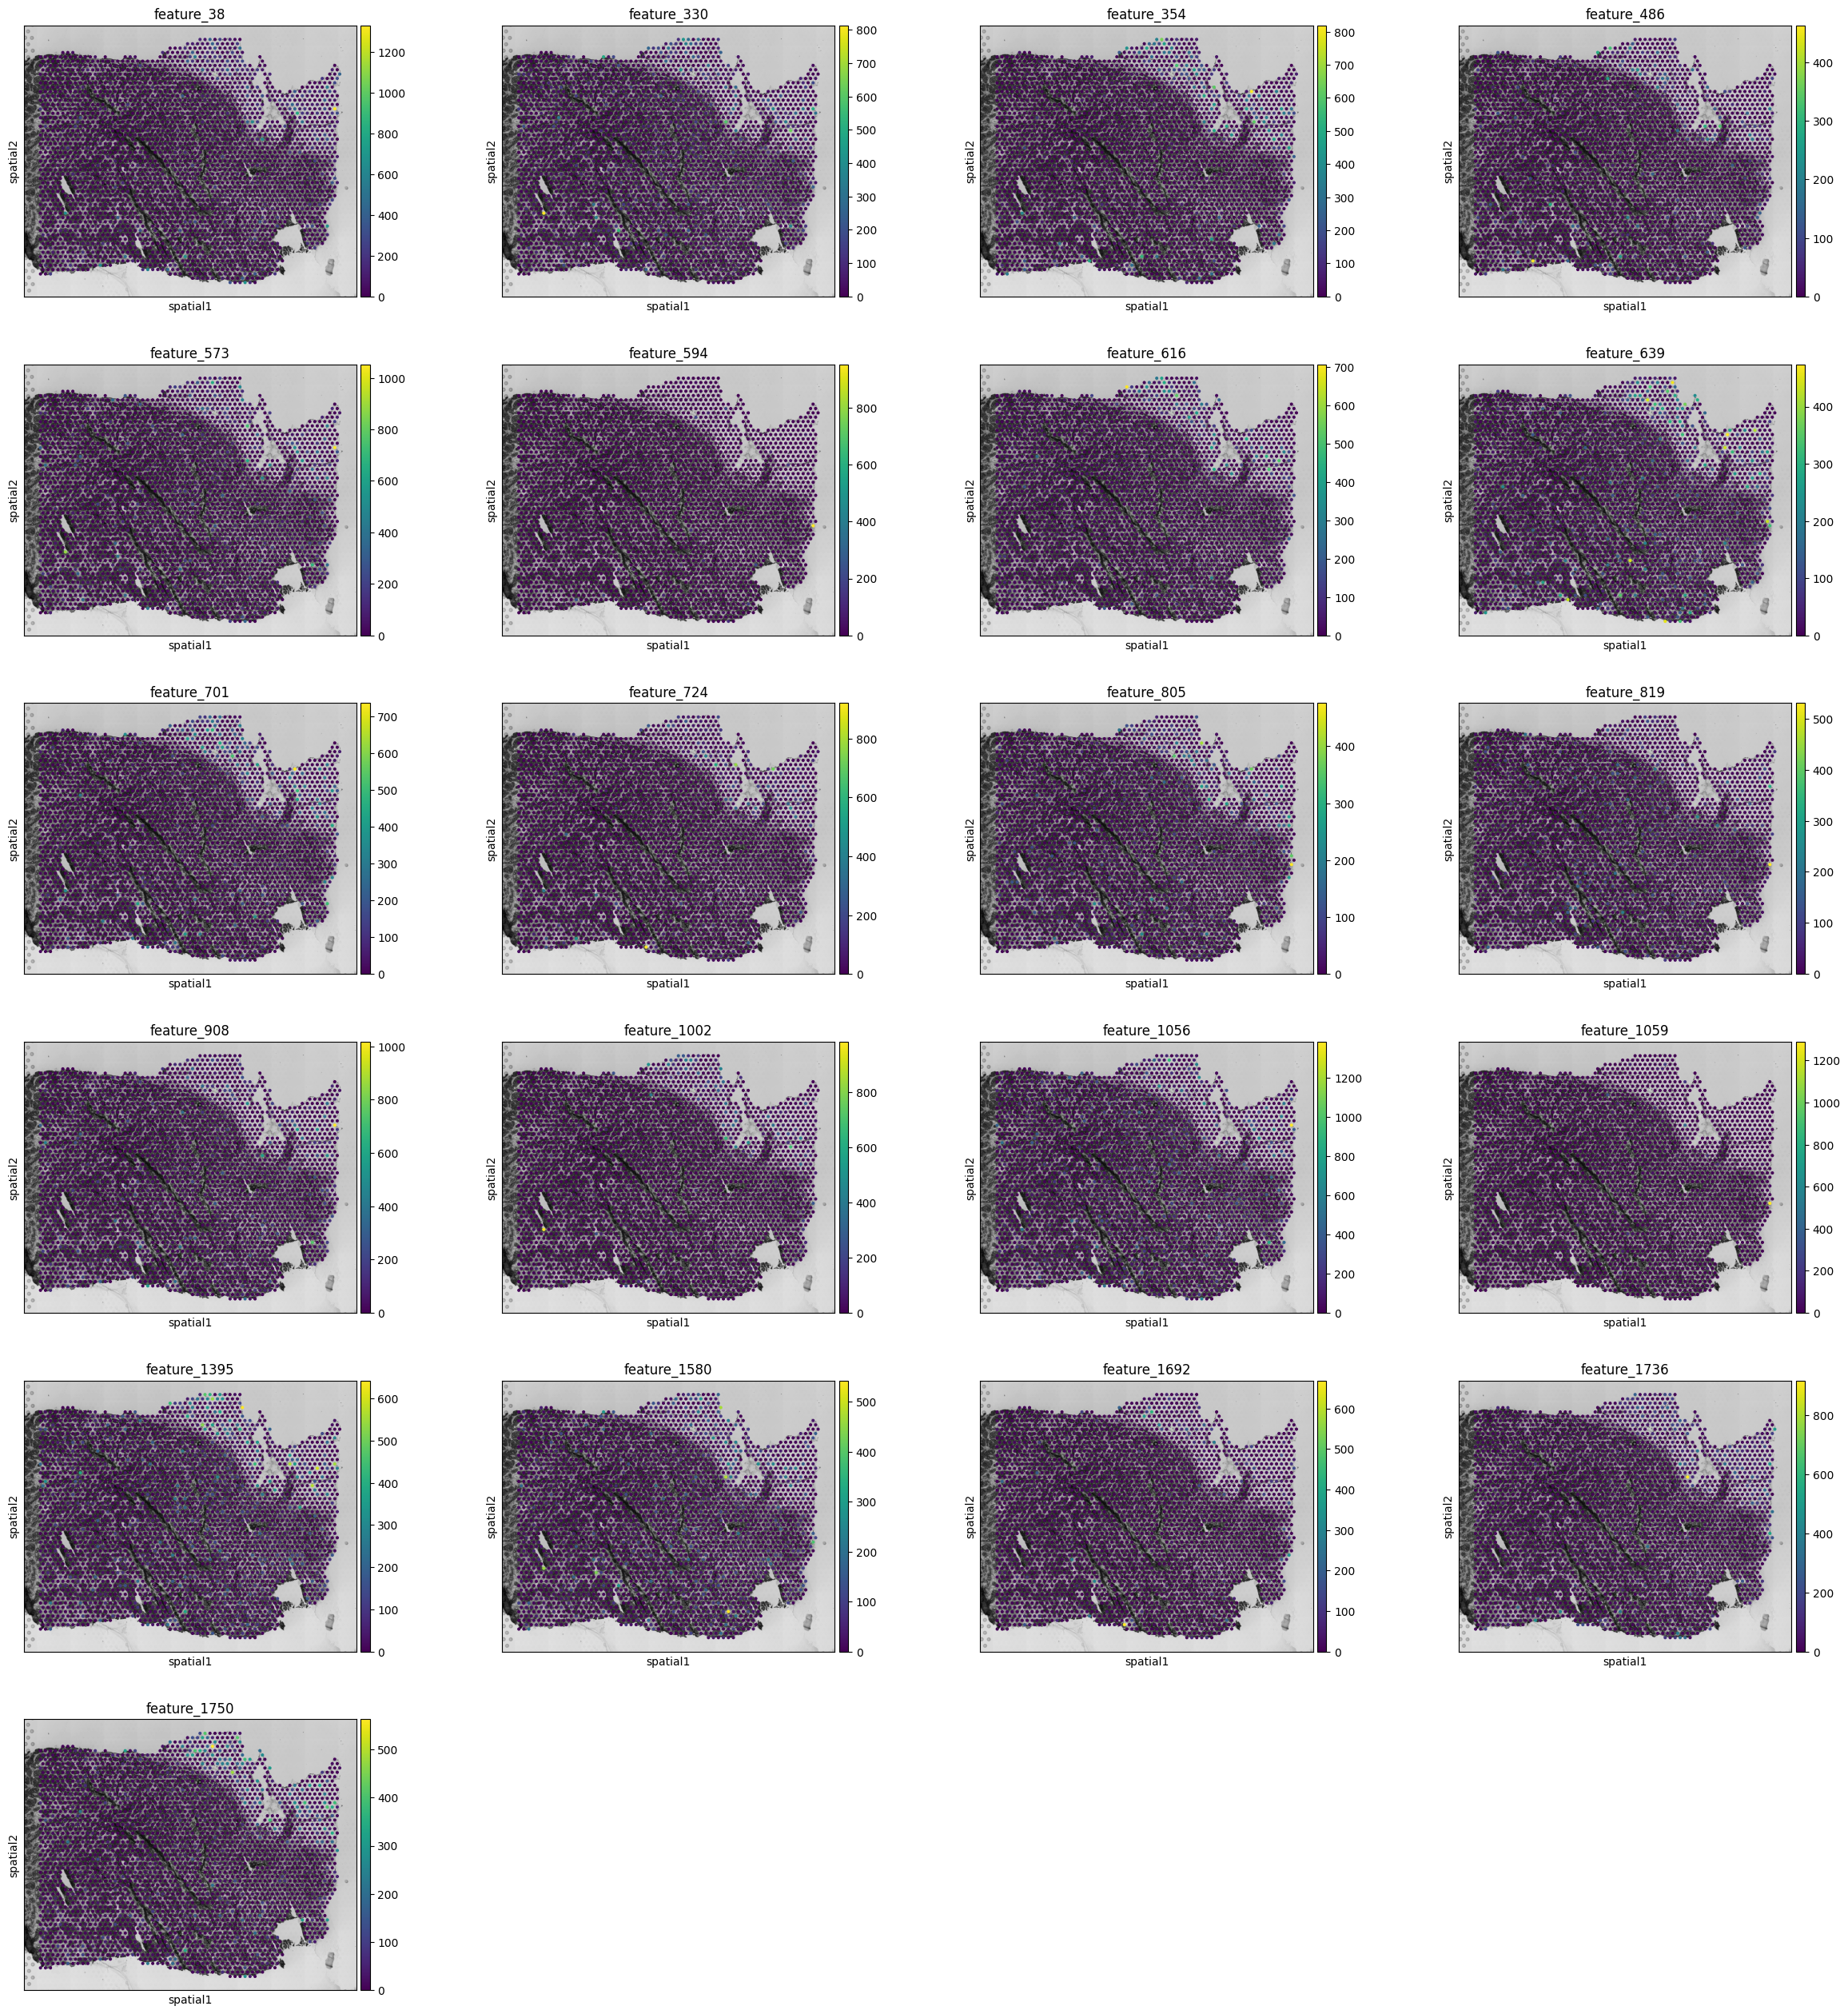

In [6]:
sc.pl.spatial(im_features_ad, 
              color = used_features_names, 
              bw=True) # bw for clarity

 It looks like these image features are pretty sparse. This could mean a couple of things.
 I trust the regularization, but let's go back to figure out what the best model would capture.

In [7]:
linear_output = linear_model.LinearRegression()
linear_output.fit(
    X = im_features_ad.to_df(),
    y = enrichments_ad.to_df())
# Here's what our best could be:
print(linear_output.score(
    X = im_features_ad.to_df(),
    y = enrichments_ad.to_df()))

0.6875809551793822


 Seems like a lot of our features are being eliminated. This could either mean that our regulization is too agressive, or that we just do not have enough nonsparse features.
 This leaves us with two options:

 * Refit the model with different parameters
 * Transfer learning train our model to do enrichment predictions